In [1]:
from mpmath.identification import transforms
from sklearn.datasets import fetch_openml 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn.functional as F 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim 
import torchmetrics.functional as metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchviz import make_dot
from torchvision import transforms
from sklearn.model_selection import train_test_split

C:\ProgramData\anaconda3\envs\TORCH_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# as_frame=False : ndarray 형식으로 반환
fashion_data = fetch_openml(name='mnist_784', parser='auto', as_frame=False)

In [3]:
feature=fashion_data['data']
target=fashion_data['target']

In [4]:
np.unique(target, return_counts=True) # 균형적인 데이터

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958],
       dtype=int64))

In [5]:
feature =feature/255.

In [6]:
feature

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
feature.shape

(70000, 784)

In [8]:
feature = feature.reshape(-1,1,28,28)

In [9]:
target=target.astype(int)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(feature,target,test_size=0.2,stratify=target,random_state=4)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,stratify=y_train,random_state=4)

In [11]:
class DLDataset(Dataset):
    
    # 초기화 함수 콜백함수(callback funcaion)
    def __init__(self, x_data, y_data):
        super().__init__()
        # ndarray ==> tensor
        self.feature=torch.FloatTensor(x_data)
        self.target=torch.LongTensor(y_data)
        
        
    # 데이터셋의 갯수 체크 함수 콜백함수(callback funcaion)
    def __len__(self):
        return self.target.shape[0]
    
    
    # 특정 인덱스 데이터+라벨 반환 콜백함수(callback funcaion)
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [12]:
# all_dataset = DLDataset(feature, target)

In [13]:
trainDS = DLDataset(x_train,y_train)
validDS = DLDataset(x_val,y_val)
testDS = DLDataset(x_test,y_test)

In [14]:
# all_dataset.feature.shape, all_dataset.target.shape

In [15]:
# trainDS, validDS, testDS = random_split(all_dataset, [0.7,0.1,0.2], generator=torch.Generator().manual_seed(42))

In [16]:
len(trainDS),len(validDS),len(testDS)

(50400, 5600, 14000)

In [17]:
trainDL = DataLoader(trainDS, batch_size=32)
validDL = DataLoader(validDS, batch_size=32)
testDL = DataLoader(testDS,   batch_size=32)

In [18]:
len(trainDL),len(validDL),len(testDL)

(1575, 175, 438)

In [19]:
for (X_train, y_train) in trainDL:
    print('X_train:', X_train.size(), 'type:', X_train.type()) 
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


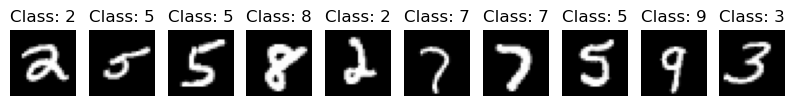

In [20]:
plt.figure(figsize=(10 ,1))
for i,(X_train, y_train) in enumerate(trainDL):
    if i == 10 : break
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)), cmap='gray')
    plt.title('Class: ' + str(y_train[i].item()))

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()       # in_channels : 채널수, out_channels : 커널수
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding = 1) 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1) # padding = 1: same padding
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 사이즈만 줄임 그 외 하는거 없음 - 반으로 줄임 # stride = 2 : 두칸씩 움직여라 / 기본 1 
        self.fc1 = nn.Linear(7 * 7 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x) # 14 * 14
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x) # 7 * 7
        
        x = x.view(-1, 7*7*16)  # 이미지 수, 이미지 데이터
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

In [22]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

EPOCHS = 10

model = CNN().to(DEVICE)

OPTIMIZER = torch.optim.Adam(model.parameters(), lr = 0.001)

LF = nn.CrossEntropyLoss()

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 2)

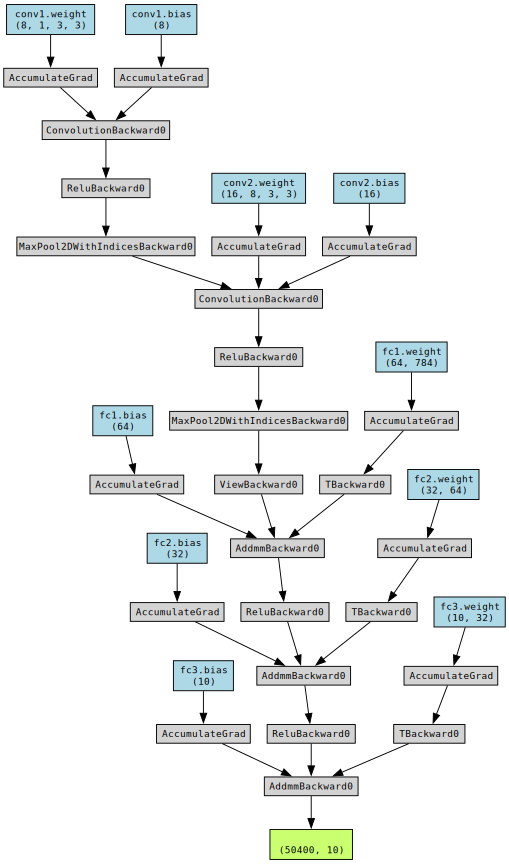

In [23]:
make_dot(model(trainDS.feature), params = dict(model.named_parameters()))

In [24]:
def training(dl):
    model.train()
    lossList = []
    accList = []
    for (img,label) in dl:
        img = img.to(DEVICE)
        label = label.to(DEVICE)
        OPTIMIZER.zero_grad()
        output = model(img)
        loss = LF(output, label)
        loss.backward()
        OPTIMIZER.step()
        f1 = metrics.f1_score(output, label,task='multiclass', num_classes= 10 )
        lossList.append(loss.item())
        accList.append(f1)
    train_loss = sum(lossList)/len(lossList)
    train_acc = sum(accList)/len(accList)
    return train_loss,train_acc

In [25]:
def testing( dl):
    model.eval()
    lossList = []
    accList = []
    
    with torch.no_grad():
        for (img,label) in dl:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            output = model(img)
            loss = LF(output, label)
            lossList.append(loss.item())
            f1 = metrics.f1_score(output, label,task='multiclass', num_classes= 10 )
            accList.append(f1)
    valid_loss = sum(lossList)/len(lossList)
    valid_acc = sum(accList)/len(accList)
    return valid_loss,valid_acc

In [26]:
train_report = [[],[]]
val_report = [[],[]]
for epoch in range(1,EPOCHS+1):
    train_loss, train_acc = training(trainDL)
    valid_loss, valid_acc = testing(validDL)
    train_report[0].append(train_loss)
    train_report[1].append(train_acc)
    val_report[0].append(valid_loss)
    val_report[1].append(valid_acc)
    print(f'[EPOCH: {epoch}]')
    print(f"Train Loss : {train_loss:.4f}, \tTrain Accuracy : {train_acc:.2f} % ")
    print(f"Test Loss : {valid_loss:.4f}, \t Test Accuracy : {valid_acc:.2f} % ")
    
    if SCHEDULER.num_bad_epochs > SCHEDULER.patience:
        print(f'조기 종료 at epoch {epoch}')
        break

[EPOCH: 1]
Train Loss : 0.3018, 	Train Accuracy : 0.90 % 
Test Loss : 0.1046, 	 Test Accuracy : 0.97 % 
[EPOCH: 2]
Train Loss : 0.0895, 	Train Accuracy : 0.97 % 
Test Loss : 0.0710, 	 Test Accuracy : 0.98 % 
[EPOCH: 3]
Train Loss : 0.0616, 	Train Accuracy : 0.98 % 
Test Loss : 0.0624, 	 Test Accuracy : 0.98 % 
[EPOCH: 4]
Train Loss : 0.0480, 	Train Accuracy : 0.98 % 
Test Loss : 0.0569, 	 Test Accuracy : 0.98 % 
[EPOCH: 5]
Train Loss : 0.0393, 	Train Accuracy : 0.99 % 
Test Loss : 0.0576, 	 Test Accuracy : 0.98 % 
[EPOCH: 6]
Train Loss : 0.0325, 	Train Accuracy : 0.99 % 
Test Loss : 0.0599, 	 Test Accuracy : 0.98 % 
[EPOCH: 7]
Train Loss : 0.0253, 	Train Accuracy : 0.99 % 
Test Loss : 0.0550, 	 Test Accuracy : 0.98 % 
[EPOCH: 8]
Train Loss : 0.0229, 	Train Accuracy : 0.99 % 
Test Loss : 0.0620, 	 Test Accuracy : 0.98 % 
[EPOCH: 9]
Train Loss : 0.0190, 	Train Accuracy : 0.99 % 
Test Loss : 0.0696, 	 Test Accuracy : 0.98 % 
[EPOCH: 10]
Train Loss : 0.0163, 	Train Accuracy : 1.00 % 
Test 

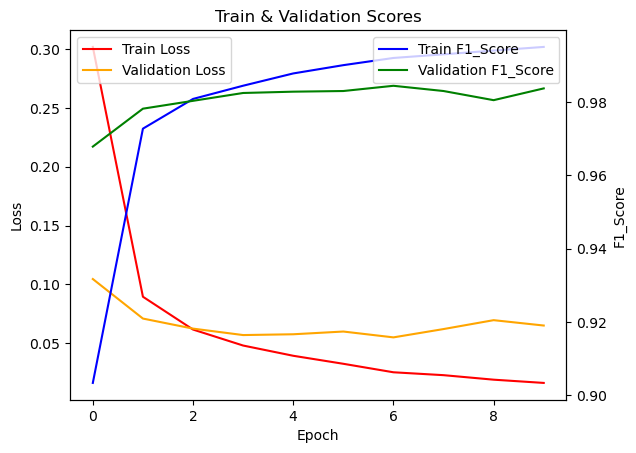

In [27]:
fig, ax1 = plt.subplots()  


ax1.plot(train_report[0], label='Train Loss', color='red')
ax1.plot(val_report[0], label='Validation Loss', color='orange')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(train_report[1], label='Train F1_Score', color='blue')
ax2.plot(val_report[1], label='Validation F1_Score', color='green')
ax2.set_ylabel('F1_Score')
ax2.set_xlabel('Epoch')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.xlabel('Epoch')  
plt.title('Train & Validation Scores')
plt.show()

In [28]:
def predict(dl):
    model.eval()
    predList = []
    labelList = []
    for img, label in dl:
        with torch.no_grad():
            pre = model(img)
        pred = torch.argmax(pre, dim=1)
        predList.extend(pred.tolist())
        labelList.extend(label.tolist())

    correct = torch.sum(torch.tensor(predList) == torch.tensor(labelList)).item()

    acc = correct / len(labelList)
    print(f'정확도: {acc}')


In [29]:
predict(testDL)

정확도: 0.9845


In [37]:
import os
import cv2

def predict_one(filename):
    test_img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if test_img is None:
        raise ValueError('no file')
    prepro = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((28,28)),
        transforms.ToTensor()
    ])
    test_img = prepro(test_img)-255/255.
    # 이미지에 배치 차원 추가
    test_img = test_img.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pre = model(test_img)
        print(pre)
    pre = torch.argmax(pre).item()
    true = int(os.path.splitext(filename)[0][-1])
    plt.imshow(test_img.squeeze().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'[True {true} / Pre {pre}]')
    if true == pre:
        print('예측 성공!')
    else:
        print('예측 실패..')
    plt.show()


tensor([[-0.3300, -0.3802, -0.0705,  0.3268, -2.4119, -0.0195, -0.6614, -0.7446,
         -0.8817, -0.5398]])
예측 실패..


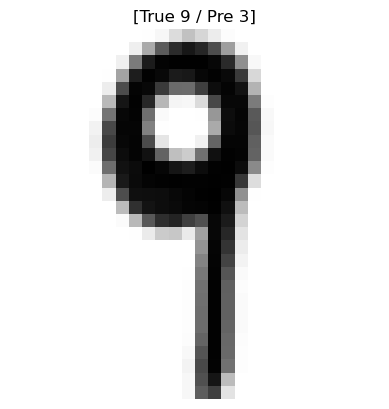

In [38]:
predict_one('../data/mnist/test9.jpg')

tensor([[-1.2381,  0.6419,  0.8653,  1.0600, -5.1097, -0.5521, -1.4413, -1.6767,
         -3.7451, -2.5908]])
예측 실패..


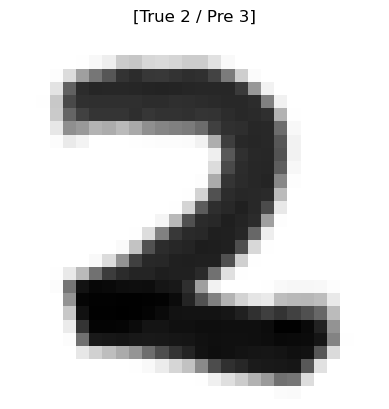

In [39]:
predict_one('../data/mnist/test2.jpg')

tensor([[-1.4431, -2.6598,  1.3999,  0.2580, -1.9239, -2.4058, -3.5688, -1.9621,
          0.3022, -0.1604]])
예측 성공!


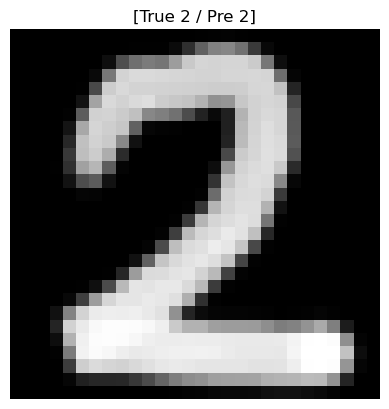

In [40]:
predict_one('../data/mnist/testb2.jpg')

tensor([[-0.8889,  0.1161,  0.3881,  1.6165, -4.7243, -0.1338, -1.0427, -1.1860,
         -2.1540, -2.8305]])
예측 실패..


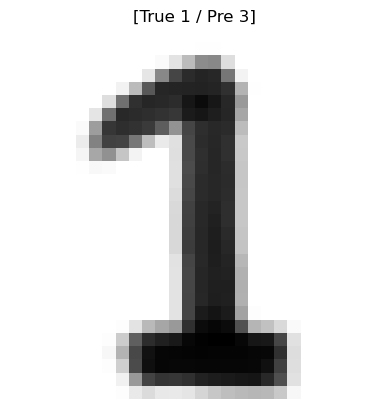

In [41]:
predict_one('../data/mnist/test1.jpg')

tensor([[-2.3620,  0.0424,  0.6594,  2.4490, -7.0694, -0.3061, -1.3092, -1.2439,
         -2.7478, -4.1667]])
예측 실패..


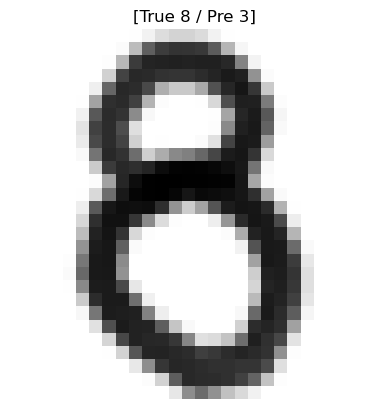

In [42]:
predict_one('../data/mnist/test8.jpg')

tensor([[-4.5846, -2.8245, -3.1493,  2.9471, -5.4577,  2.8046, -2.7428, -1.9954,
         -1.8898, -1.3702]])
예측 실패..


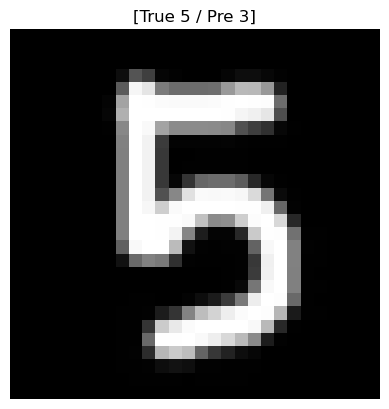

In [43]:
predict_one('../data/mnist/testb5.jpg')